Overview
*** Write an overview of the case study that you are working on. (MINIMUM 200 words) ***
1. When it comes to questions and answers humans have a different way of
understanding and answering the question asked. In this case study we are going
to understand the same with the help of (Question-Answer) dataset from top
websites.
2. Humans have a unique way of answering any question asked. We first understand
the question, the intuition behind it, the significance of the question etc. With
machine it is different.
3. In this problem, we will help the machine understand these aspects of question
with the help of a question-answer dataset from different websites.
4. In our dataset we have 30 different aspects of question-answer like
‘question_conversational’, ‘question_body_critical’, ‘answer_helpful’ etc.
5. Our goal will be to find the scores for each of these aspects with the help of our
training dataset. In our training dataset we have scores associated with each of
these labels in the range of [0,1]. We will make our model learn these aspects and
try to evaluate the same for our test dataset.


In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras.backend as K
import gc
import os
from scipy.stats import spearmanr
from math import floor, ceil
import seaborn as sns

np.set_printoptions(suppress=True)

In [35]:
from google.colab import  drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
os.listdir('/content/gdrive/My Drive/case study2')

['train.csv', 'sample_submission.csv', 'test.csv', 'train.csv.zip']

In [0]:
path='/content/gdrive/My Drive/case study2/'

**Reading Our Datsets**

In [38]:
#train dataset
train_df=pd.read_csv(path+'train.csv')
train_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [39]:
#test data
test_df=pd.read_csv(path+'test.csv')
test_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


In [40]:
#submission file
submission=pd.read_csv(path+'sample_submission.csv')
submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


In [41]:
#columns in our train_data
train_columns=train_df.columns
test_columns=test_df.columns
print('-'*15+'Train Columns'+'-'*15)
print(train_columns)
print('-'*15+'Train data Shape'+'-'*15)
print(train_df.shape)
print('-'*15+'Test Columns'+'-'*15)
print(test_columns)
print('-'*15+'Test data Shape'+'-'*15)
print(test_df.shape)

---------------Train Columns---------------
Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible'

We thus have 6079 training points and 476 test points/ We have 41 train columns and 11 test columns. For the 30 columns we have to predict value for the test dataset. So, let us have a look at these 30 values

In [42]:
target_values=train_columns[12:]
print('Target columns are: ')
target_values

Target columns are: 


Index(['question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

For these 30 columns we need to find value for each point in the test dataset in the range of [0,1]

Now let us have a look at how these target_values are distributed across our training dataset

In [43]:
train_df[target_values].describe()

,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
count,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,0.595301,0.057301,0.698525,0.772633,0.793689,0.587478,0.507275,0.238745,0.004469,0.429978,0.284915,0.038137,0.010035,0.030762,0.065225,0.497587,0.166063,0.386385,0.000823,0.799931,0.925408,0.654823,0.960054,0.968626,0.854680,0.479547,0.130641,0.502468,0.908254
std,0.219470,0.182196,0.350938,0.303023,0.336622,0.135900,0.185987,0.335057,0.045782,0.365952,0.368826,0.153635,0.074240,0.138065,0.197582,0.423138,0.257301,0.383384,0.020489,0.178420,0.114836,0.107666,0.086926,0.074631,0.130743,0.422921,0.225718,0.407097,0.100708
min,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.200000,0.000000,0.000000,0.000000,0.333333
25%,0.444444,0.000000,0.500000,0.666667,0.666667,0.444444,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.888889,0.666667,1.000000,1.000000,0.800000,0.000000,0.000000,0.000000,0.888889
50%,0.555556,0.000000,0.666667,1.000000,1.000000,0.555556,0.444444,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000,0.833333,1.000000,0.666667,1.000000,1.000000,0.866667,0.500000,0.000000,0.500000,0.888889
75%,0.777778,0.000000,1.000000,1.000000,1.000000,0.666667,0.666667,0.333333,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.666667,0.000000,1.000000,1.000000,0.666667,1.000000,1.000000,0.933333,1.000000,0.333333,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Category Distribution**

In our training dataset we had different categories listed. Each question belong to one of these categories. So, let us explore this column seeing how our data is distributed across the same.

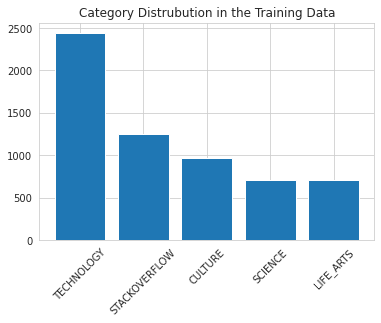

In [44]:
categ=train_df['category'].value_counts()
plt.bar(categ.index,height=categ)
plt.title('Category Distrubution in the Training Data')
plt.xticks(rotation=45)
plt.show()

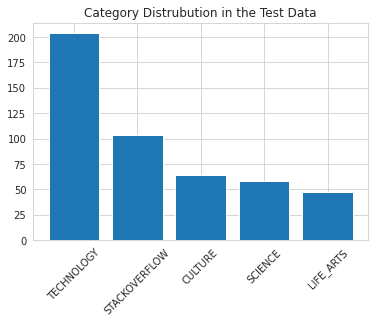

In [45]:
categ=test_df['category'].value_counts()
plt.bar(categ.index,height=categ)
plt.title('Category Distrubution in the Test Data')
plt.xticks(rotation=45)
plt.show()

From the above graphs it is clear that the distribution of categories is same across the training and the test dataset. Also, we have most of the question and answers related to technology than others


**Host Distribution**

Now let us see how the data is distributed for different hosts in the training and the test dataset.

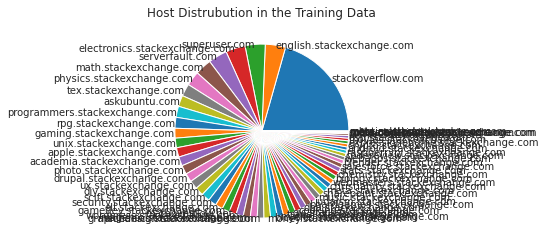

In [46]:
host=train_df['host'].value_counts()
plt.pie(host,labels=host.index,labeldistance=1)
plt.title('Host Distrubution in the Training Data')
plt.show()

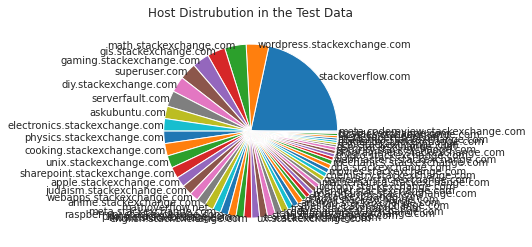

In [47]:
host=test_df['host'].value_counts()
plt.pie(host,labels=host.index,labeldistance=1)
plt.title('Host Distrubution in the Test Data')
plt.show()

From the above two plots it is clear that of all the hosts almost one fourth of the data is coming from stackoverflow. Also, this scneario is same for both our training dataset and test dataset. Hence, we can say that also for the host the distribution of our dataset is same.

**Now Let us Have a Look on The Distribution of Target Variables**

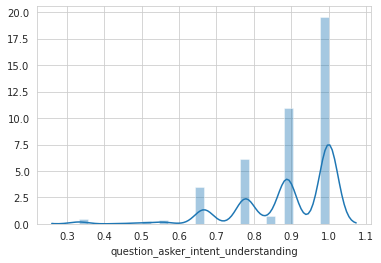

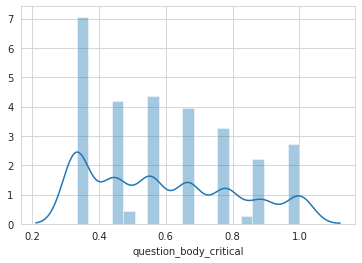

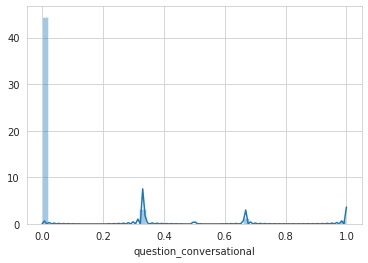

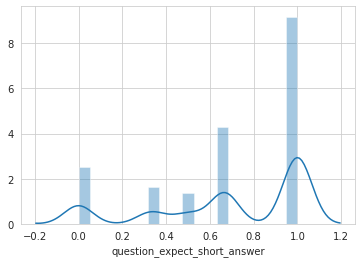

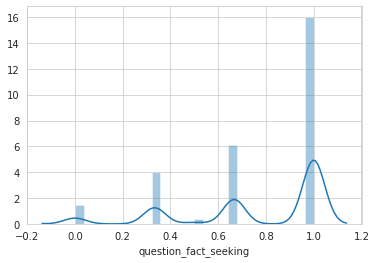

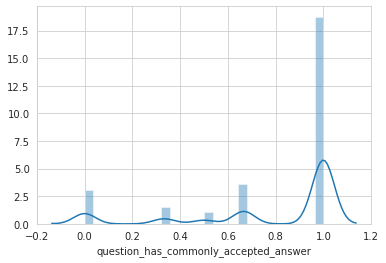

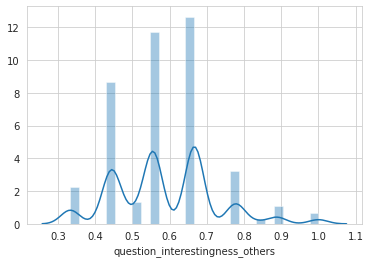

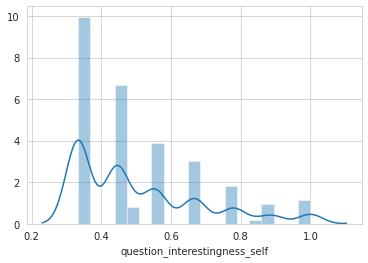

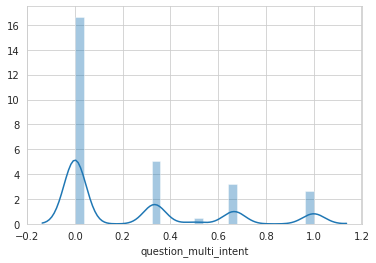

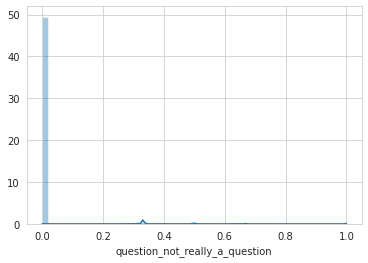

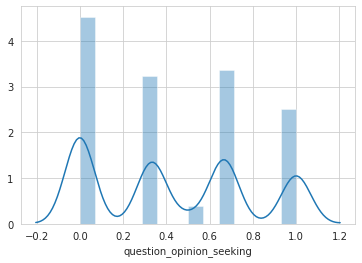

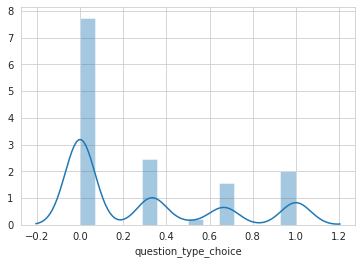

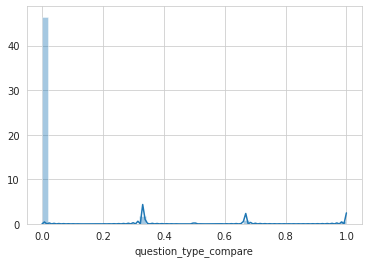

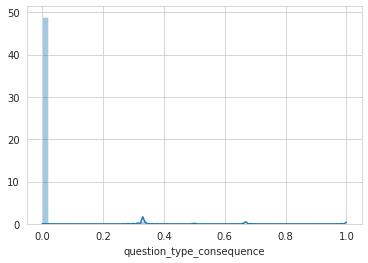

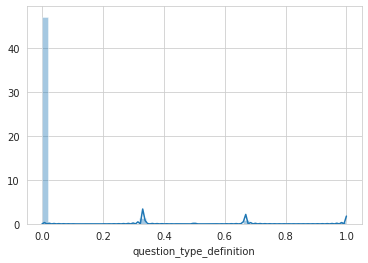

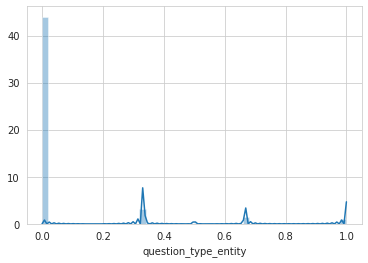

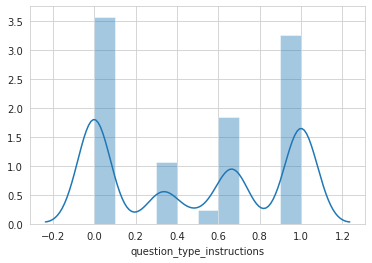

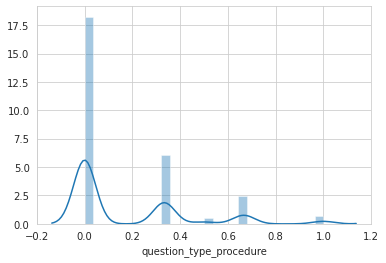

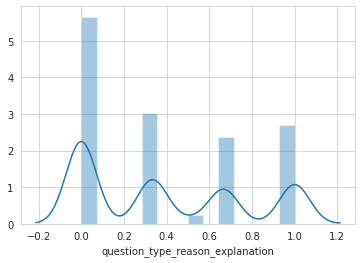

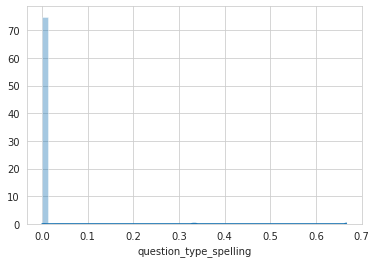

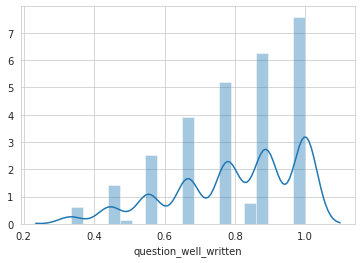

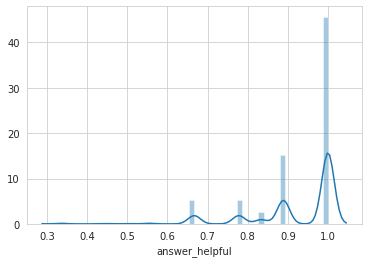

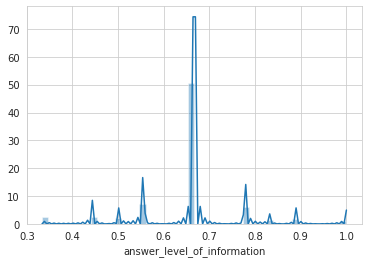

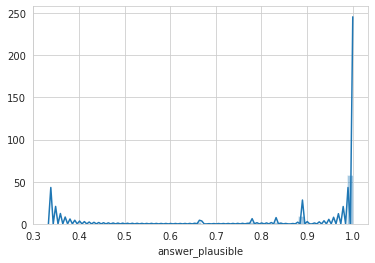

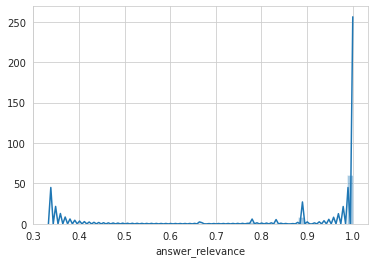

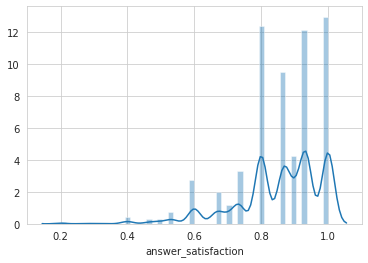

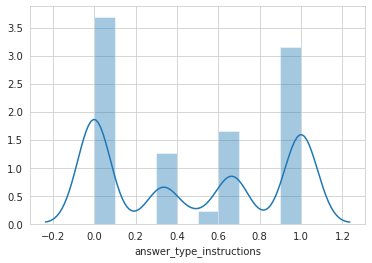

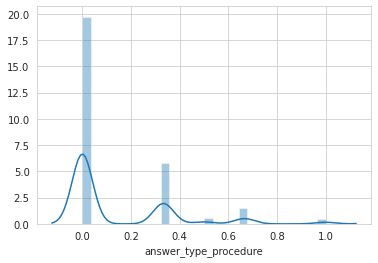

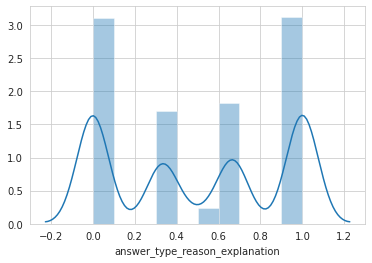

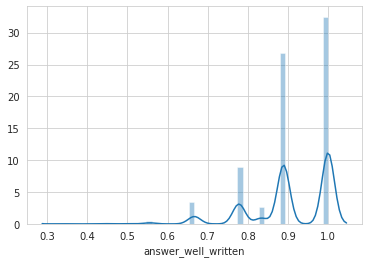

In [48]:
sns.set_style('whitegrid');
features = train_df.columns[11:]
#code reference-->https://pythonbasics.org/seaborn_pairplot/
for i in range(0,len(features)):
    sns.distplot(train_df[features[i]],label=features[i],kde=True)
  
    plt.show()

**Observation from Distribution Plot**
From the above plots it is clear while few target variables have ranging values, few of them have a same value in most of the cases

#Relation Between the Target Values

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


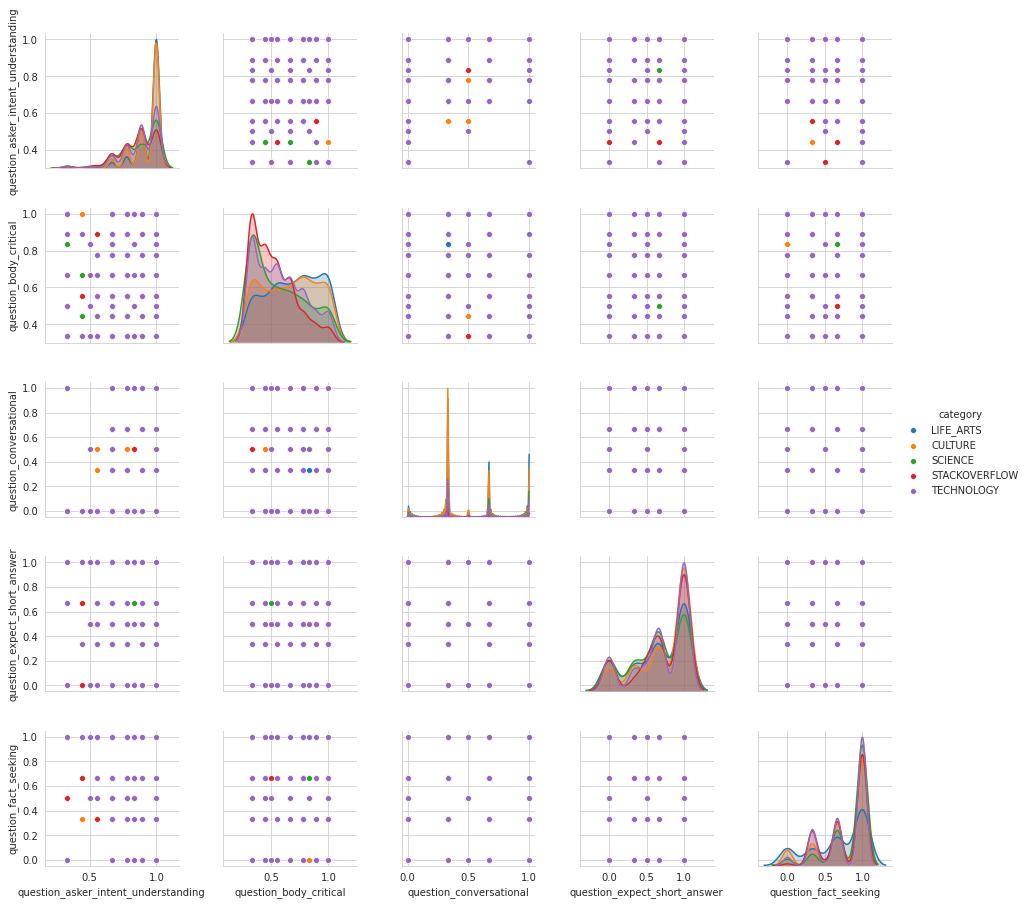

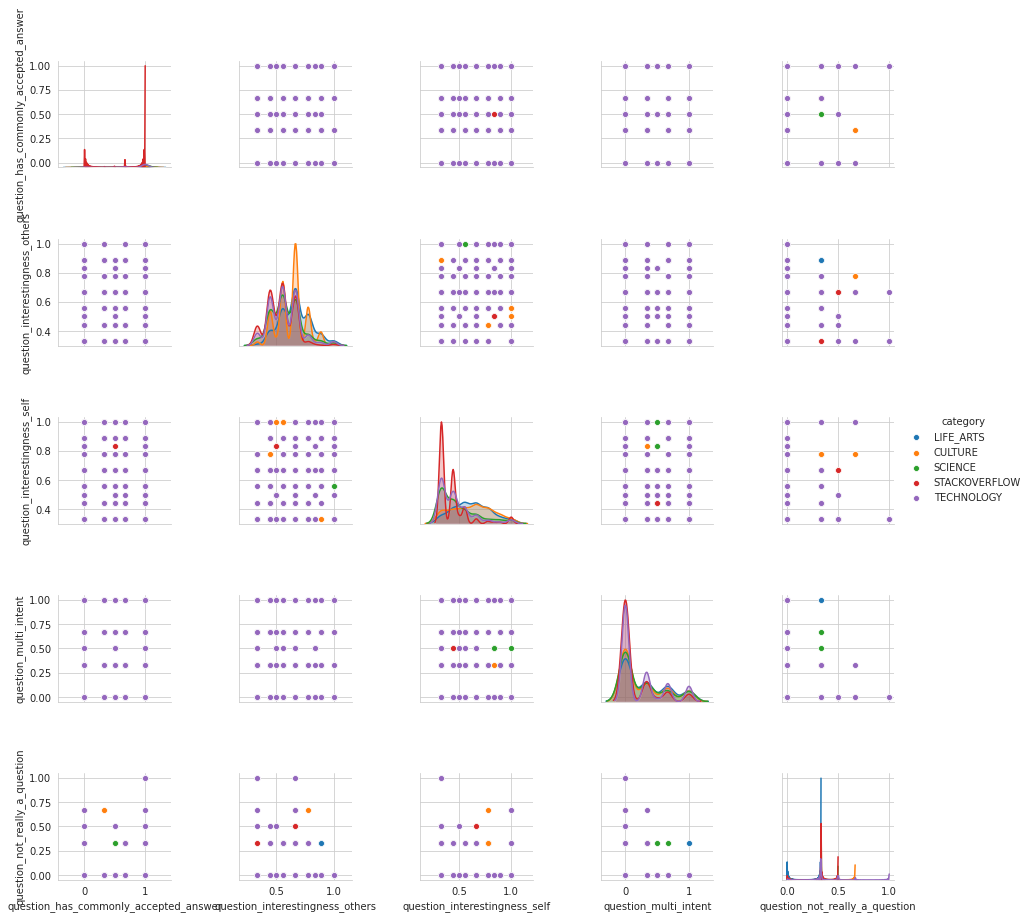

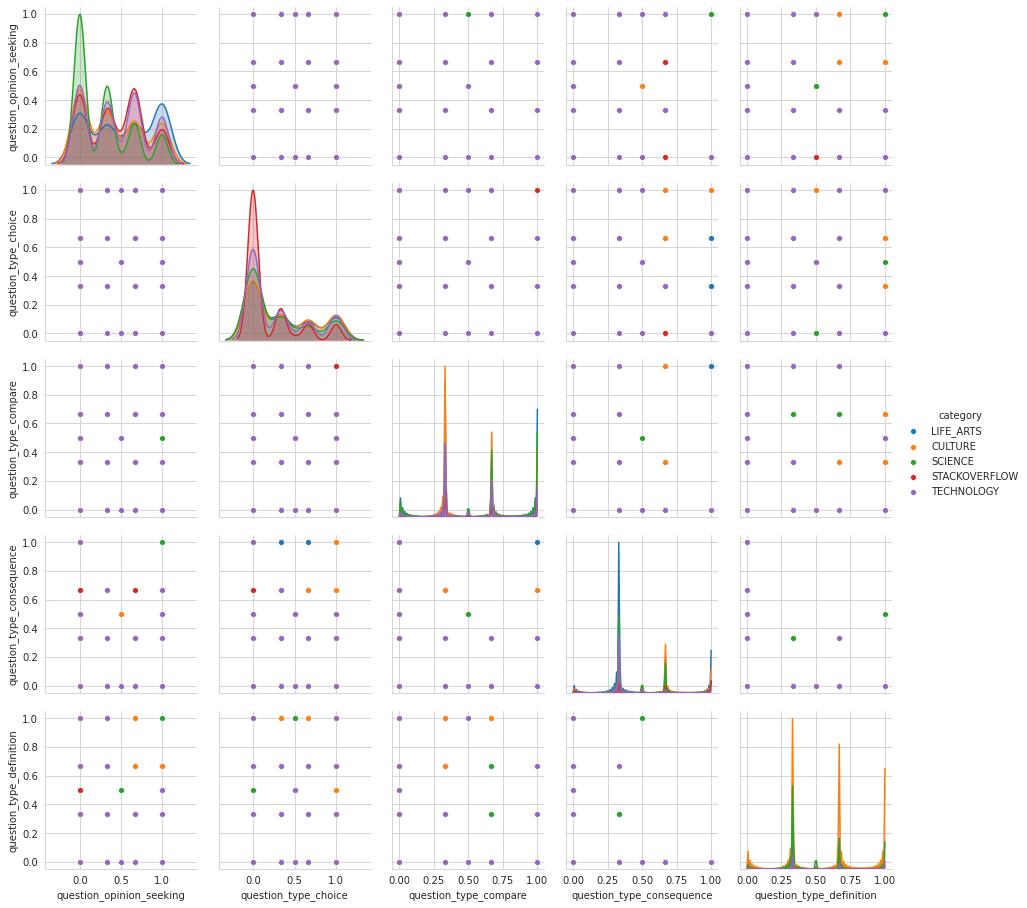

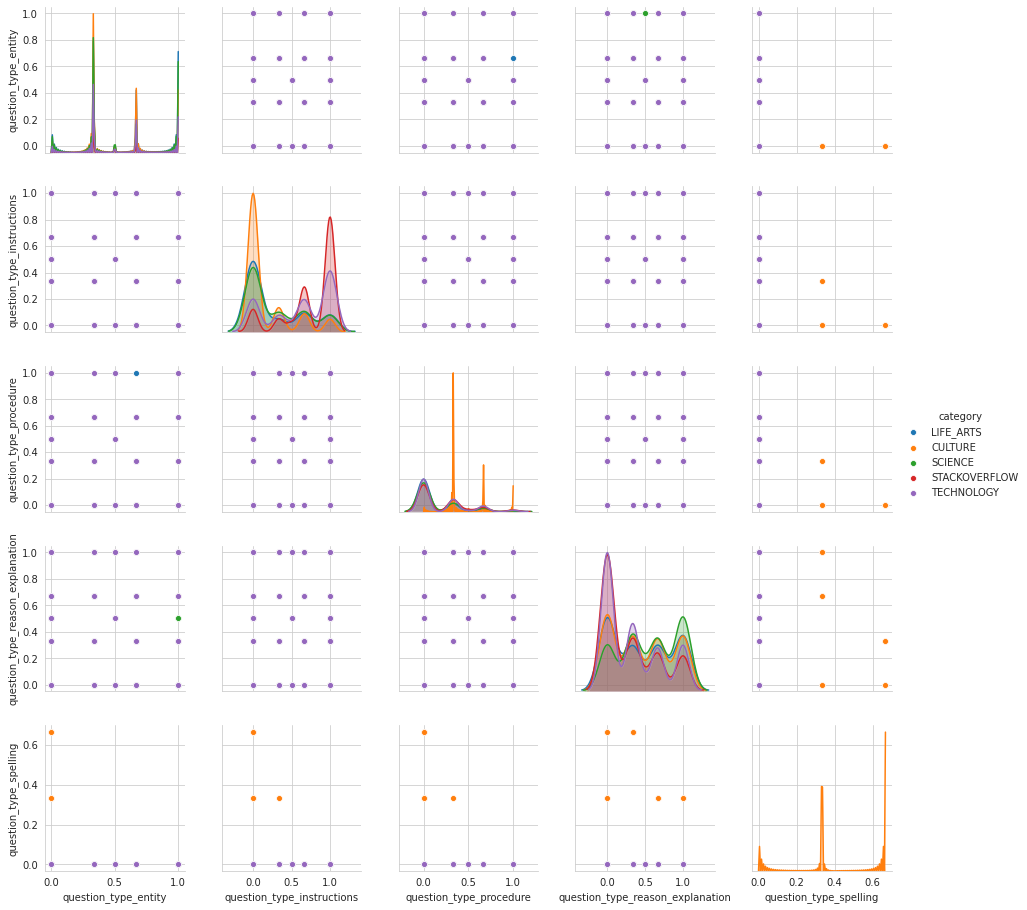

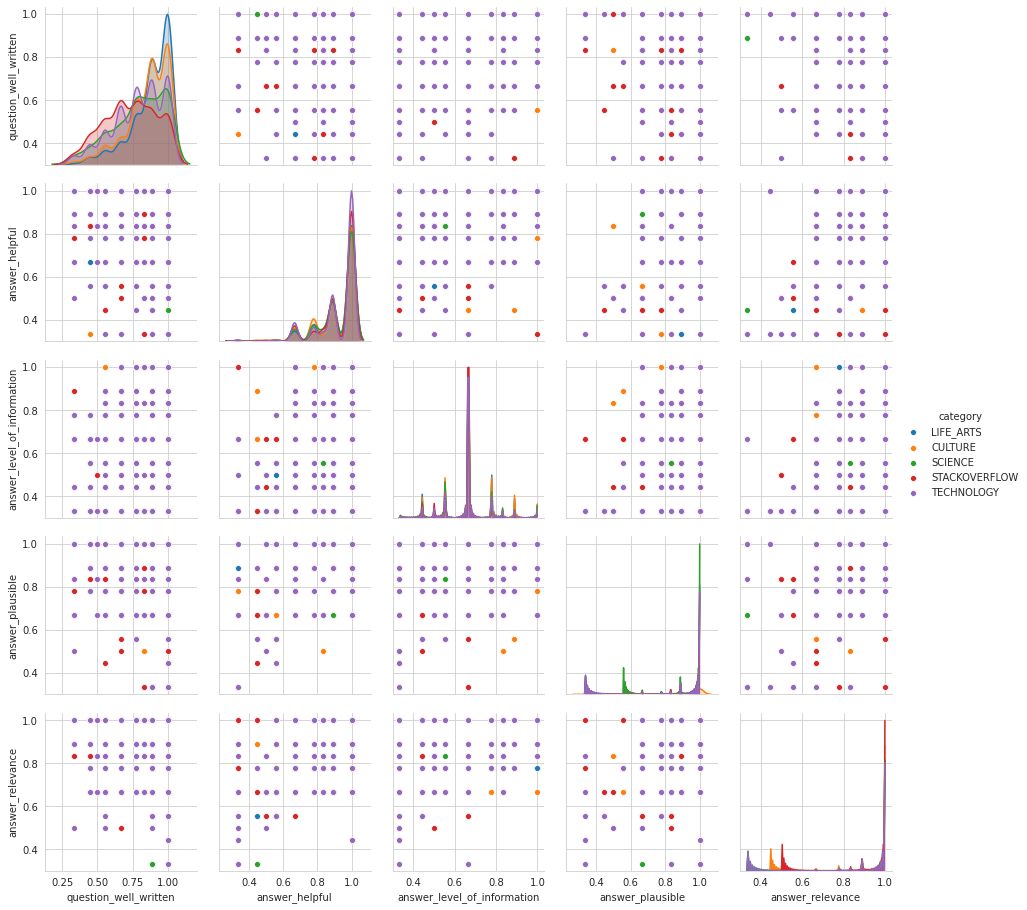

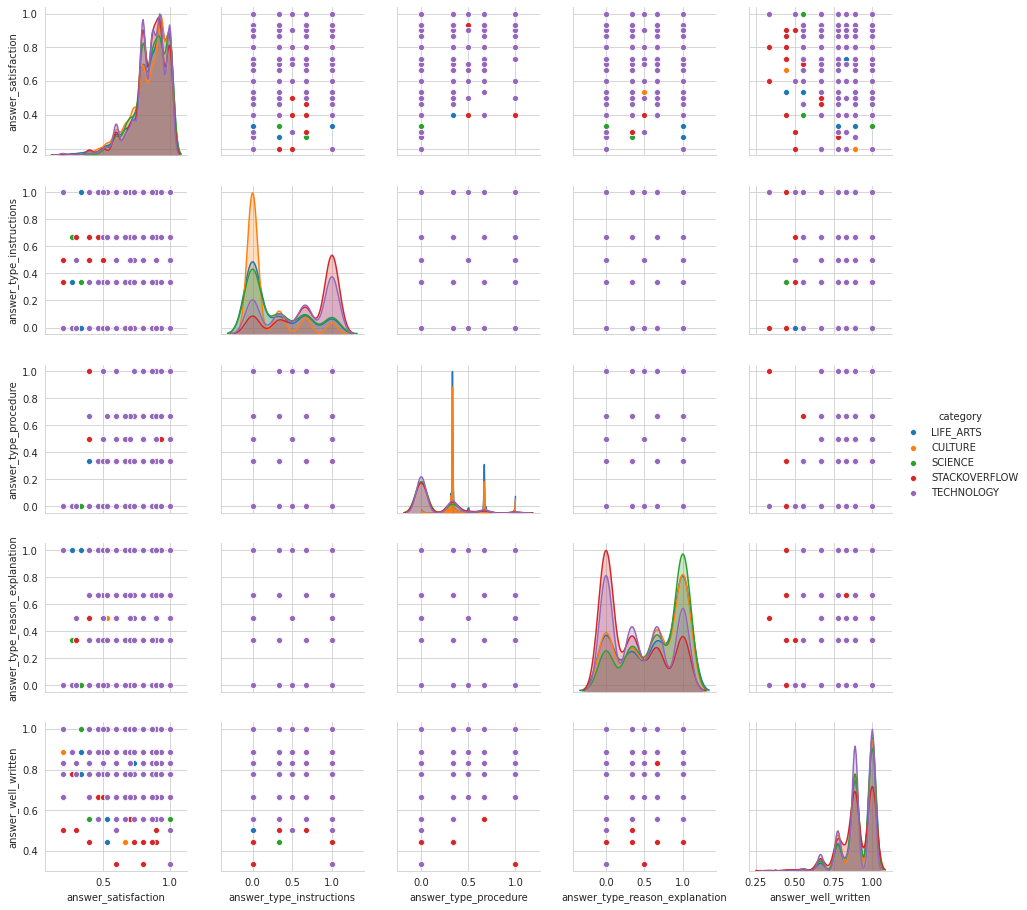

In [49]:
features = train_df.columns[11:]
for i in range(0,len(features),5):
    sns.pairplot(train_df,hue='category',vars=[features[i],features[i+1],features[i+2],features[i+3],features[i+4]])
 

#Observation from the above plots

1. Therre is not much relation between two taret categories as it can be seen.
2. for question_answer_intent_understanding, question_conversational, question_interestingness_others, question_type_compare,question_type_definition,question_type_instructions, question_type_procedures, question_type_spelling, question_type_instructions most for after a ceratin offset most of the values fall in the category of CULTURE, whereas the other categories overlap.
3. For question_opinion_seeking, question_type_consequence, question_well_written, the cateory LIFA_Arts tend to have a more values for a certain range. but mostly is it overlapping with other categories.
4. For question_type_seeking, question_type_reason_explanation, answer_type_instructions, question_opinion_seeking we have a distinguishable rane for SCIENCE, which does make sense as science question and answers should have high reasoning.
5. For most of the taret variables STACKOVERFLOW category covers a major reigon as we have most of the question-answer pairs from this cateory.
6. For answer_type_reason_explanation, for answer_type_procedure, answer_type_instructions, answer_type_reason_explanation, answer_type_instructions,question_multi_intent there exists a range and offset for category TECHNOLOGY.

**Word Clouds**

Now, next let us see what are the common words in our train and test dataset question and answers. 

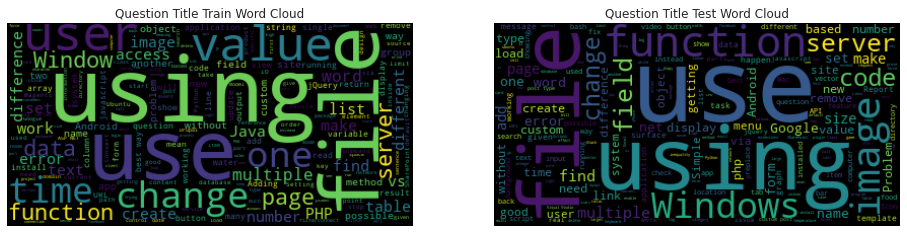

In [50]:
from wordcloud import WordCloud, STOPWORDS

fig, axes = plt.subplots(1, 2, figsize=(16, 18))
train_cat = ' '.join(train_df['question_title'].values)
test_cat=' '.join(test_df['question_title'].values)
wordcloud1 = WordCloud(stopwords=STOPWORDS).generate(train_cat)
wordcloud2 = WordCloud(stopwords=STOPWORDS).generate(test_cat)
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].set_title('Question Title Train Word Cloud')
axes[0].axis("off")
axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].set_title('Question Title Test Word Cloud')
axes[1].axis("off")

fig.show()


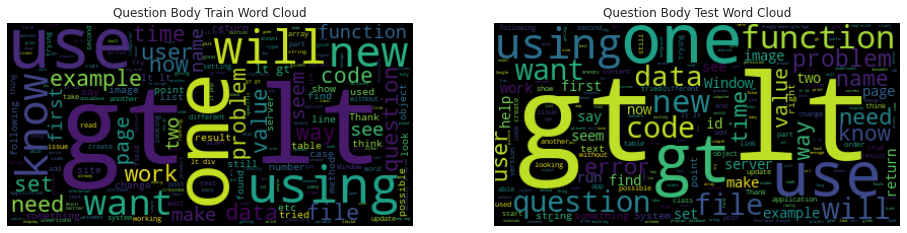

In [51]:
from wordcloud import WordCloud, STOPWORDS

fig, axes = plt.subplots(1, 2, figsize=(16, 18))
train_cat = ' '.join(train_df['question_body'].values)
test_cat=' '.join(test_df['question_body'].values)
wordcloud1 = WordCloud(stopwords=STOPWORDS).generate(train_cat)
wordcloud2 = WordCloud(stopwords=STOPWORDS).generate(test_cat)
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].set_title('Question Body Train Word Cloud')
axes[0].axis("off")
axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].set_title('Question Body Test Word Cloud')
axes[1].axis("off")

fig.show()

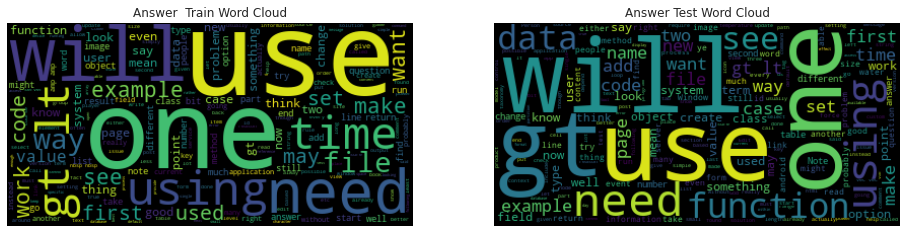

In [52]:
from wordcloud import WordCloud, STOPWORDS

fig, axes = plt.subplots(1, 2, figsize=(16, 18))
train_cat = ' '.join(train_df['answer'].values)
test_cat=' '.join(test_df['answer'].values)
wordcloud1 = WordCloud(stopwords=STOPWORDS).generate(train_cat)
wordcloud2 = WordCloud(stopwords=STOPWORDS).generate(test_cat)
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].set_title('Answer  Train Word Cloud')
axes[0].axis("off")
axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].set_title('Answer Test Word Cloud')
axes[1].axis("off")

fig.show()

**Observations**

From the above wordclouds it is clear that the distrubution of words is alsmost same across the training and the test dataset for all three text fields. Hence, with the help of out training data we can correctly find patterns in out test dataset

**Correlation in Target Variables**
Next let us have a look at the correlation in our target variables and see if deducing one target variable will help in deducing others or not


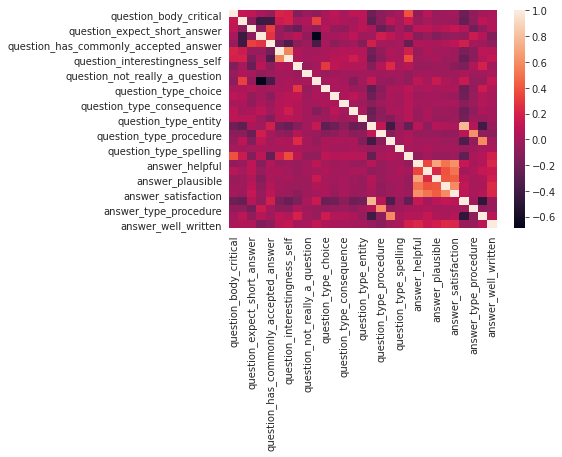

In [53]:
sns.heatmap(train_df[target_values].corr())

**Observation**

From the above heatmap it is clear that the target variables are not strongly correlated. 

**Data Cleaning & Featurization**

Now as we have explored our data it is time to text data in our dataset and obtain new features depending on our dataset

**Remove Punctuations & Decontracted Words**

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"couldn\'t", " could not", phrase)
    phrase = re.sub(r"couldnt", " could not", phrase)
    phrase = re.sub(r"didn\'t", " did not", phrase)
    phrase = re.sub(r"doesn\'t", " does not", phrase)
    phrase = re.sub(r"don\'t", " do not", phrase)
    phrase = re.sub(r"hadn\'t", " had not", phrase)
    phrase = re.sub(r"hasn\'t", " has not", phrase)
    phrase = re.sub(r"haven\'t", " have not", phrase)
    phrase = re.sub(r"he\'ll", " he will", phrase)
    phrase = re.sub(r"he\'d", " he would", phrase)
    phrase = re.sub(r"didn\'t", " did not", phrase)
    phrase = re.sub(r"wasn\'t", " was not", phrase)
    phrase = re.sub(r"you\'re", " you are", phrase)
    return phrase

In [0]:
#code reference: https://www.kaggle.com/codename007/start-from-here-quest-complete-eda-fe


def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()   
    text = " ".join(text)
    return(text)

In [0]:
#cleaning of train data
train_df['question_body']=train_df['question_body'].apply(clean_text)
train_df['question_body']=train_df['question_body'].apply(decontracted)
train_df['question_title']=train_df['question_body'].apply(clean_text)
train_df['question_title']=train_df['question_body'].apply(decontracted)
train_df['answer']=train_df['question_body'].apply(clean_text)
train_df['answer']=train_df['question_body'].apply(decontracted)

#cleaning of test data
test_df['question_body']=test_df['question_body'].apply(clean_text)
test_df['question_body']=test_df['question_body'].apply(decontracted)
test_df['question_title']=test_df['question_body'].apply(clean_text)
test_df['question_title']=test_df['question_body'].apply(decontracted)
test_df['answer']=test_df['question_body'].apply(clean_text)
test_df['answer']=test_df['question_body'].apply(decontracted)


**Printing Our Cleaned Data**

In [57]:
train_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,after playing around with macro photography on...,after playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,after playing around with macro photography on...,rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,i am trying to understand what kinds of places...,i am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,i am trying to understand what kinds of places...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,i am working on a pcb that has through-hole co...,i am working on a pcb that has through-hole co...,Joe Baker,https://electronics.stackexchange.com/users/10157,i am working on a pcb that has through-hole co...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,"an affidavit, from what i understand, is basic...","an affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"an affidavit, from what i understand, is basic...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,i am trying to make a binary image. i want mor...,i am trying to make a binary image. i want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,i am trying to make a binary image. i want mor...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [58]:
test_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,i see questions/information online about how t...,i see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,i see questions/information online about how t...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,i am new to wordpress. i have issue with featu...,i am new to wordpress. i have issue with featu...,Anu,https://wordpress.stackexchange.com/users/72927,i am new to wordpress. i have issue with featu...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"to experiment i started a bot game, toggled in...","to experiment i started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,"to experiment i started a bot game, toggled in...",Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,i have used my raspberry pi as a torrent-serve...,i have used my raspberry pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,i have used my raspberry pi as a torrent-serve...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,i have bought delhi-london return flights for ...,i have bought delhi-london return flights for ...,Amit,https://travel.stackexchange.com/users/29089,i have bought delhi-london return flights for ...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com
